In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_products = pd.read_csv('Products.csv')
data_transactions = pd.read_csv('Transactions.csv')

In [3]:
data_customers = pd.read_csv('Customers.csv')

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

merged_data = pd.merge(data_transactions, data_customers, on='CustomerID')

# Feature engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'TransactionDate': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpent', 'TransactionCount', 'Recency']

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpent', 'TransactionCount', 'Recency']])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(scaled_features)

# Generate lookalike recommendations
lookalikes = {}
for idx, customer_id in enumerate(customer_features['CustomerID']):
    similar_indices = similarity_matrix[idx].argsort()[-4:-1][::-1]  # Get top 3 similar customers
    similar_customers = customer_features['CustomerID'].iloc[similar_indices].tolist()
    scores = similarity_matrix[idx][similar_indices].tolist()
    lookalikes[customer_id] = list(zip(similar_customers, scores))

# Convert to DataFrame
lookalike_list = []
for cust_id, similar in lookalikes.items():
    for similar_cust, score in similar:
        lookalike_list.append([cust_id, similar_cust, score])

lookalike_df = pd.DataFrame(lookalike_list, columns=['CustomerID', 'LookalikeID', 'SimilarityScore'])

# Save to CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

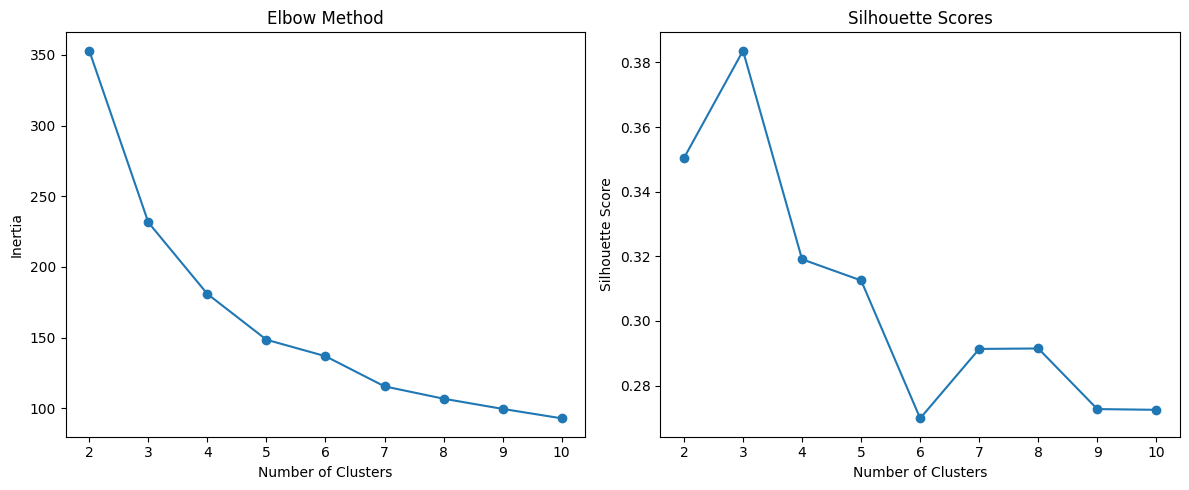

Number of clusters formed: 4
Davies-Bouldin Index: 1.0131995743060562


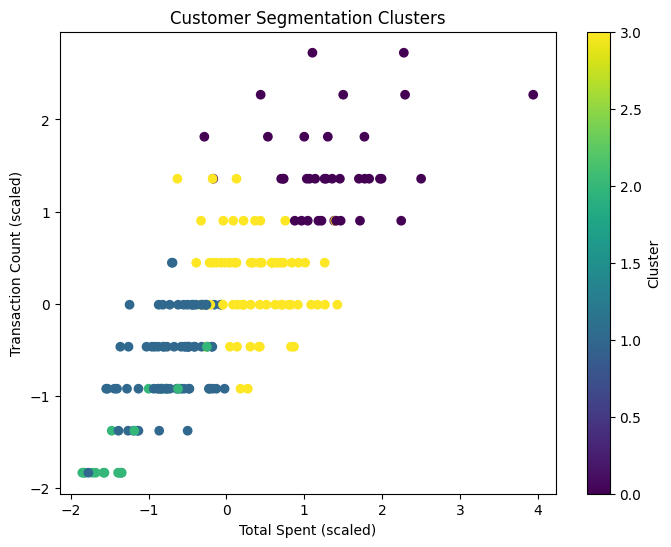

In [5]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose the optimal number of clusters (e.g., based on the Elbow Method)
optimal_k = 4  # Replace with the number you determine from the plots

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])

# Output the clustering results
print(f'Number of clusters formed: {optimal_k}')
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters (optional)
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=customer_features['Cluster'], cmap='viridis', marker='o')
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spent (scaled)')
plt.ylabel('Transaction Count (scaled)')
plt.colorbar(label='Cluster')
plt.show()

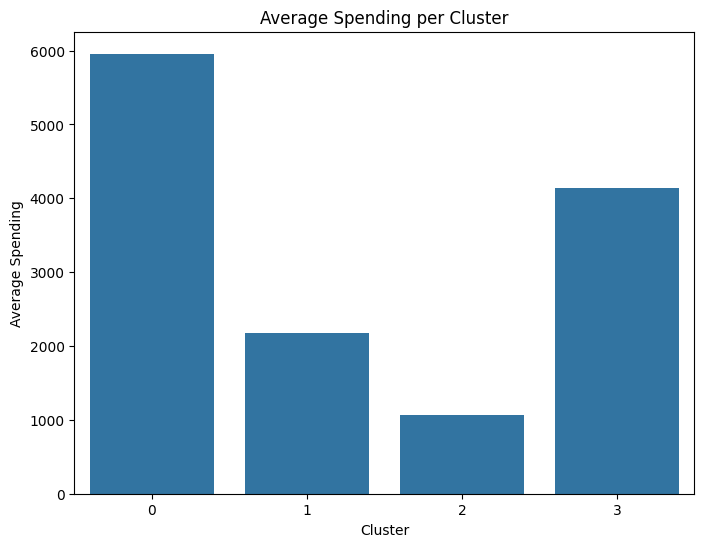

In [6]:
import seaborn as sns

# Calculate average spending per cluster
cluster_summary = customer_features.groupby('Cluster')['TotalSpent'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='TotalSpent', data=cluster_summary)
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

In [7]:
import pandas as pd

# Assuming customer_features DataFrame already contains the cluster labels
# Example DataFrame structure:
# customer_features = pd.DataFrame({
#     'CustomerID': [...],
#     'TotalSpent': [...],
#     'TransactionCount': [...],
#     'Recency': [...],
#     'Cluster': [...]
# })

# Calculate average characteristics per cluster
cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalSpent': 'mean',
    'TransactionCount': 'mean',
    'Recency': 'mean'
}).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   Cluster   TotalSpent  TransactionCount     Recency
0        0  5958.357895          8.236842   65.710526
1        1  2176.816883          3.714286   81.649351
2        2  1070.562353          1.764706  274.823529
3        3  4145.723881          5.537313  110.641791


In [8]:
# Define marketing strategies based on cluster characteristics
for index, row in cluster_summary.iterrows():
    if row['TotalSpent'] > 500:  # High-value customers
        print(f"Cluster {row['Cluster']}: Target with exclusive deals and loyalty programs.")
    elif row['TransactionCount'] > 10:  # Frequent customers
        print(f"Cluster {row['Cluster']}: Encourage upselling and cross-selling.")
    elif row['Recency'] < 30:  # Recent customers
        print(f"Cluster {row['Cluster']}: Implement onboarding campaigns.")
    else:
        print(f"Cluster {row['Cluster']}: Focus on re-engagement strategies.")

Cluster 0.0: Target with exclusive deals and loyalty programs.
Cluster 1.0: Target with exclusive deals and loyalty programs.
Cluster 2.0: Target with exclusive deals and loyalty programs.
Cluster 3.0: Target with exclusive deals and loyalty programs.


In [9]:
# Example KPIs to track
kpi_metrics = {
    'Customer Retention Rate': 0.0,  # Placeholder for actual calculation
    'Conversion Rate': 0.0,          # Placeholder for actual calculation
    'Average Order Value': 0.0        # Placeholder for actual calculation
}

# Print KPIs
print("KPIs to Monitor:")
for kpi, value in kpi_metrics.items():
    print(f"{kpi}: {value}")

KPIs to Monitor:
Customer Retention Rate: 0.0
Conversion Rate: 0.0
Average Order Value: 0.0


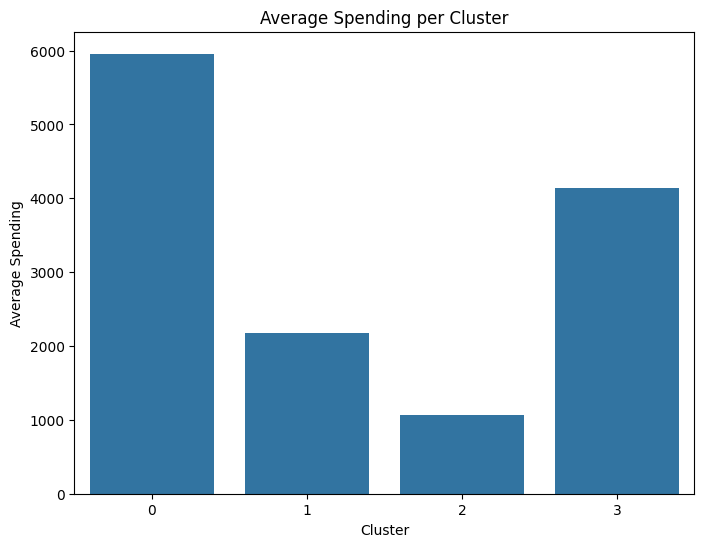

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of average spending per cluster
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='TotalSpent', data=cluster_summary)
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()